In [1]:
def extract(file, poly_task):
    for line in open(file, "r"):
        if poly_task in line:
            return int(line.split(" ")[-2])

In [4]:
import os

path = '/home/haobchen/data/task_polybench/'
def polypench_analyze(focused):
    result = {}
    for dirname, subdirlist, filelist in os.walk(path):
        if dirname == path:
            for dir in subdirlist:
                result[dir] = []
            continue
        
        # skip root directory is skipped
        for fname in filelist:
            subtask = os.path.basename(os.path.normpath(dirname))
            if focused in fname:
                data = extract(dirname + "/" + fname, subtask)
                result[subtask].append(data)
        
    return result

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

poly_native = polypench_analyze("result_native")
poly_native = pd.DataFrame(poly_native)
poly_native = poly_native.transpose()

poly_pobf = polypench_analyze("result_pobf")
poly_pobf = pd.DataFrame(poly_pobf)
poly_pobf = poly_pobf.transpose()

poly = {}
poly["native"] = {}
poly["pobf"] = {}

for i in poly_native.index:
    poly["native"][i] = np.average(poly_native.loc[i])
    poly["pobf"][i] = np.average(poly_pobf.loc[i])

poly = pd.DataFrame(poly)
for i in poly.index:
    poly.loc[i, "overhead"] = ((poly.loc[i, "pobf"] / poly.loc[i, "native"]) -1) * 100

np.average(poly["overhead"])

-0.02835108093783328

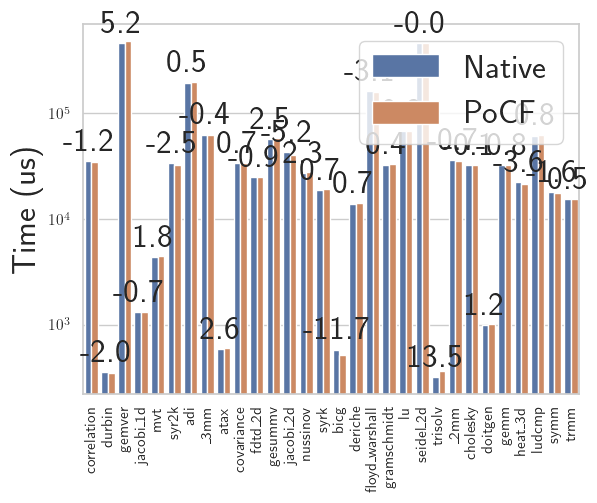

In [7]:
sns.set(style="whitegrid")
xs = []
ys = []
hue = []
overhead = []
for i in poly.index:
    xs.append(i)
    xs.append(i)
    ys.append(poly["native"][i])
    ys.append(poly["pobf"][i])
    hue.append("Native")
    hue.append("PoCF")

plt.rcParams['mathtext.default'] = 'sf'
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 24
plt.rc('legend',fontsize=24)

assert(len(xs) == len(ys))
g = sns.barplot(x=xs, y=ys, hue=hue)
g.set_yscale("log")
g.set_xticklabels(g.get_xticklabels(), rotation=90)

overhead_precentage = "  " + poly["overhead"].round(1).astype(str)

g.bar_label(g.containers[0], labels = overhead_precentage, padding=3)
g.set_ylabel("Time (us)")
plt.savefig("./polybench_sgx.pdf", bbox_inches='tight')


In [48]:
times = list(range(1, 6))
times = [str(t) for t in times]
result = {}
for f in files:
    result[f] = {}
    for t in times:
        full_path = path + t + f
        for l in open(full_path, "r"):
            content = l.split(" ")
            if "===" in l or len(content) != 3:
                continue
            else:
                bench_name = content[0].split(":")
                bench_name = bench_name[-2]
                bench_data = int(content[1])
                if bench_name in result[f]:
                    result[f][bench_name] += bench_data
                else:
                    result[f][bench_name] = bench_data

In [27]:
avg = np.average(overhead)
avg

0.9975056333567124

{'Infogroup': [51027, 1352], 'Manta': [2121, 698], 'Yelp': [6185, 367], 'Foursquare': [9402, 346], 'Yellowpages': [2260, 288], 'Factual': [17928, 282], 'MapQuest': [4842, 201], 'Localeze': [1091, 37]}
             all_count  pos_count  neg_count
Infogroup        51027       1352      49675
Manta             2121        698       1423
Yelp              6185        367       5818
Foursquare        9402        346       9056
Yellowpages       2260        288       1972
Factual          17928        282      17646
MapQuest          4842        201       4641
Localeze          1091         37       1054
1352
Infogroup
698
Manta
367
Yelp
346
Foursquare
288
Yellowpages
282
Factual
201
MapQuest
37
Localeze


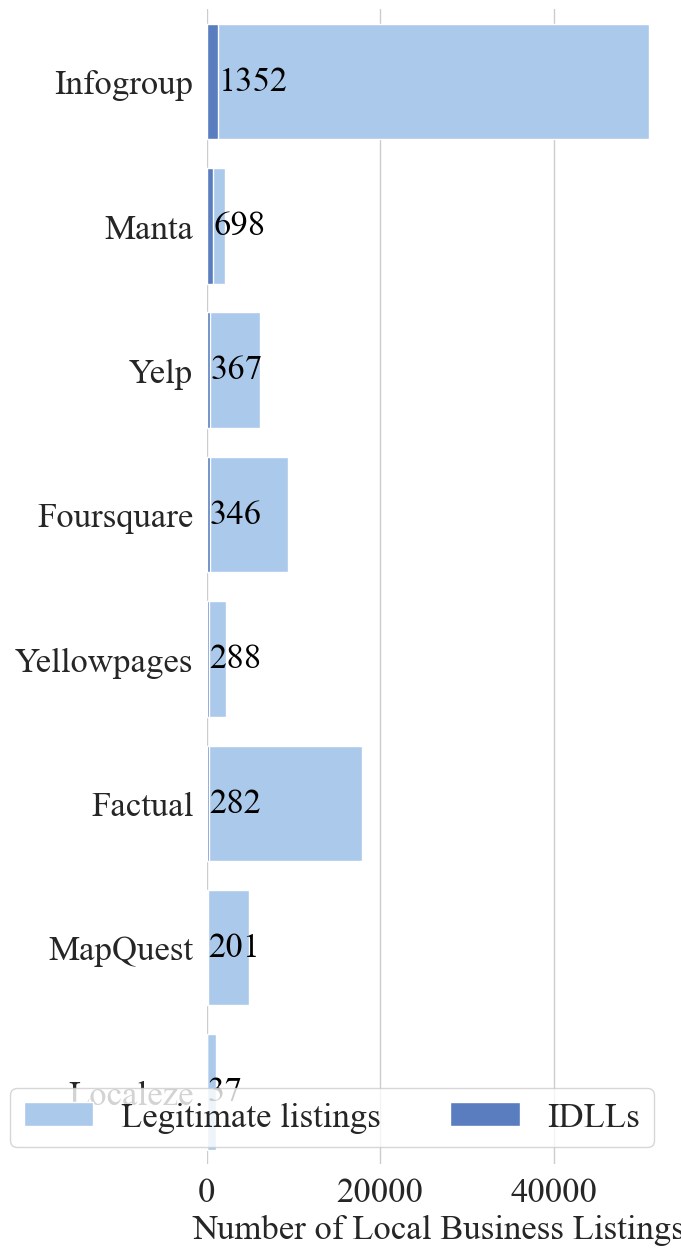

<Figure size 640x480 with 0 Axes>

In [29]:
# -*- encoding -*-
# Coding for Demystifying Local Business Search Poisoning for Illicit Drug Promotion
# Author: Zilong Lin
import pandas as pd
all_count = [('Infogroup', 51027), ('Manta', 2121), ('Yelp', 6185), ('Foursquare', 9402), ('Yellowpages', 2260), ('Factual', 17928), ('MapQuest', 4842), ('Localeze', 1091)]
pos_count = [('Infogroup', 1352), ('Manta', 698), ('Yelp', 367), ('Foursquare', 346), ('Yellowpages', 288), ('Factual', 282), ('MapQuest', 201), ('Localeze', 37)]
data = {}
for i in all_count:
    if i[0] not in data:
        data[i[0]] = []
    data[i[0]].append(i[1])
for j in pos_count:
    if j[0] not in data:
        data[j[0]] = []
    data[j[0]].append(j[1])
print(data)
for x in data:
    data[x].append(data[x][0] - data[x][1])
df = pd.DataFrame(data, index=['all_count', 'pos_count', "neg_count"]).T
print(df)
# df.columns = ['pos_count', 'all_count', "neg_count"]

import seaborn as sns
import matplotlib.pyplot as plt
fontSize = 25
sns.set(style="whitegrid")
plt.rc('font', family='Times New Roman', size=fontSize)
#设置子图的大小
f, ax = plt.subplots(figsize=(6, 15))
#导入数据集car crash dataset
# print(sns.load_dataset("car_crashes"))
# crashes = data.sort_values("all_count", ascending=False)
sns.set_color_codes("pastel")
sns.barplot(x="all_count", y=df.index, data=df, label="Legitimate listings", color="b")
sns.set_color_codes("muted")
g = sns.barplot(x="pos_count", y=df.index, data=df, label="IDLLs", color="b")
count = 0
for i, row in df.iterrows():
    print(row["pos_count"])
    print(i)
    #在柱状图上绘制该类别的数量
    g.text(x=row["pos_count"] + 50, y=count, s=str(row["pos_count"]), color="black", va="center")
    count += 1

#设置图例和坐标信息
ax.legend(ncol=2, loc="lower right", frameon=True, fontsize=fontSize)
# ax.set(ylabel="", xlabel="Number of LBLs")
ax.set_xlabel(xlabel="Number of Local Business Listings", fontsize=fontSize)
# ax.set(xlim=(0, 500000), ylabel="", xlabel="Number of IDLLs")
plt.tick_params(axis='x', labelsize=fontSize)    # 设置x轴标签大小
plt.tick_params(axis='y', labelsize=fontSize)    # 设置x轴标签大小
sns.despine(left=True, bottom=True)
plt.show()